

# Project: Investigate The Movie Database (TMDb)

### by Jérôme d'Harveng

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
> For this analysis, the TMDb dataset has been choosen (this is originally coming from Kaggle).
This data set contains information about 10,000 movies collected from The Movie Database (TMDb), including user ratings and revenue.

> **Questions Analysed**: After inspecting and cleaning this dataset, we'll focus on 2 aspects:
> 1. What are the properties of high earning movies? 
> 2. Which genres of movies are produced the most year after year?


In [12]:
# Import statements for all of the packages needed for this investigation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
%matplotlib inline
plt.style.use('seaborn-deep')

<a id='wrangling'></a>
## Data Wrangling


### General Properties

In [13]:
# Load your data 
df = pd.read_csv('TMDB.csv')

In [14]:
# visualisation of first 3 rows, in order to understand better the structure of the DB
df.head(2)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08


In [15]:
# Looking at the size of the DB
df.shape

(10866, 21)

In [16]:
# Looking at the datatypes and amount of non-null values of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

In [17]:
# isolation specifically the columns with a huge amount of null values
df.isnull().sum()

id                         0
imdb_id                   10
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      76
homepage                7930
director                  44
tagline                 2824
keywords                1493
overview                   4
runtime                    0
genres                    23
production_companies    1030
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

> The columns homepage, tagline, keywords and production_companies have a lot of null values. We'll decide in the datacleaning process to remove those from the study

In [18]:
sum(df.imdb_id.duplicated())

10

> There several duplicates in 'imdb_id'



### Data Cleaning 

> **Duplicates**: during the data wrangling process, we saw that there were 10 duplicates in the original dataset (imdb_id).
We'll delete those rows for futher analysis. And we'll check that the operation succeeded by counting the amount of remaining duplicates

In [19]:
df.drop_duplicates(inplace=True)

# we test if all duplicates were dropped
sum(df.duplicated())

0

> **Drop Columns**: for further analysis, we won't need all available columns.
We saw that the columns "homepage", "tagline", "production_companies and "keywords" have a lot of null values, besides of this we won't use them. So those will be dropped. Neither we'll we use the "overview" column.
We noticed that "imdb_id" also has some null values, but we can use "id" for identification, which don't have null values.

> Along with those, we'll drop "budget" and "revenue", because we'll use the actualized versions. 
We'll drop also the "release_date" as we'll use the "release_year".

In [20]:
df.drop(['imdb_id','budget','revenue','homepage','tagline','keywords','overview','release_date','production_companies'],axis=1,inplace=True)
df.shape

(10865, 12)

> **Revenue_adj and budget_adj**: as we'll study the earnings in question 1, it's important to clean the revenue_adj and budjet_adj. Those have a lot of zeros.

In [21]:
# check the amount of rows where or budget_adj or revenue_adj are equal to zero
df.query('budget_adj < 1 or revenue_adj < 1').shape

(7012, 12)

In [22]:
# Drop the raws where either budhet_adj or revenue_adj equals 0
df_Q1 = df.drop(df[(df.budget_adj < 1) | (df.revenue_adj < 1)].index)

> **Adding Columns**: for analysis purpose, we would like to add the column "earnings_adj", which is the difference between "revenue_adj" and "budget_adj"

In [23]:
df_Q1['earnings_adj'] = df_Q1.revenue_adj - df_Q1.budget_adj

> **Columns genres**: if we want to analyse the impact of the "genres" in question 2, we should separate the different "genres" in single categories

In [24]:
df_Q2 = df.copy()

In [25]:
# We only select the need columns for our second question
df_Q2 = df_Q2[['id','popularity','genres','vote_average','release_year']]

In [26]:
# We create a separate column for each individual genre
dummies_genres = df_Q2['genres'].str.get_dummies(sep="|")

In [27]:
df_Q2.drop(['genres'],axis=1,inplace=True)
df_Q2.head(2)

,id,popularity,vote_average,release_year
0,135397,32.985763,6.5,2015
1,76341,28.419936,7.1,2015


In [28]:
# We concatenate both previous dataframes into 1 main dataframe that will be used for the analysis
df_Q2_dum = pd.concat([df_Q2.reset_index(drop=True),dummies_genres.reset_index(drop=True)], axis=1)

In [29]:
df_Q2_dum.head(2)

,id,popularity,vote_average,release_year,Action,Adventure,Animation,Comedy,Crime,Documentary,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,135397,32.985763,6.5,2015,1,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,76341,28.419936,7.1,2015,1,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


<a id='eda'></a>
## Exploratory Data Analysis

### Research Question 1 :  Properties of high earnings movies

> **Research**: What kinds of properties are associated with movies having high earnings?
To answer, this question we'll use the "earnings" column that has been added in the Cleaning Data chapter, with
dataset df_Q1.
We'll define high earnings, as earnings being greater than the mean earnings.

In [30]:
# df_high is dataframe with only earnings higher than the average earning
df_high = df_Q1.query('earnings_adj > earnings_adj.mean()')

In [31]:
# let's have a look at the different indicators for df_high
df_high.iloc[:,1:].describe()

,popularity,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj,earnings_adj
count,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1.068000e+03,1.068000e+03,1.068000e+03
mean,2.141194,115.782772,1207.497191,6.480618,1999.354869,7.464414e+07,3.735525e+08,2.989084e+08
std,2.255302,22.255347,1315.190440,0.709058,12.804584,5.586516e+07,2.932603e+08,2.720454e+08
min,0.131526,69.000000,13.000000,4.100000,1960.000000,2.248029e+02,9.664454e+07,9.300454e+07
25%,0.998941,99.000000,332.000000,6.000000,1993.000000,3.128147e+07,1.897329e+08,1.318853e+08
50%,1.555852,113.000000,727.500000,6.500000,2003.000000,6.148773e+07,2.781974e+08,2.029346e+08
75%,2.564112,128.000000,1611.250000,7.000000,2010.000000,1.066338e+08,4.491095e+08,3.630904e+08
max,32.985763,248.000000,9767.000000,8.300000,2015.000000,3.683713e+08,2.827124e+09,2.750137e+09


In [32]:
# df_low is dataframe with only earnings lower than the average earning
df_low = df_Q1.query('earnings_adj < earnings_adj.mean()')

In [33]:
# Comparing the mean vote_average
df_low.vote_average.mean(),df_high.vote_average.mean()

(6.048653500897666, 6.480617977528089)

> High earning movies get on the average higher vote_averages

In [34]:
# Comparing the mean runtime
df_low.runtime.mean(),df_high.runtime.mean()

(106.71059245960502, 115.78277153558052)

> High earning movies last on the average longer

In [35]:
# Comparing the mean release_year
df_low.release_year.mean(),df_high.release_year.mean()

(2001.9885098743268, 1999.3548689138577)

> High earning movies were on the average released earlier 

In [36]:
# Let's see what movie had the biggest earnings
print(df_Q1.query('earnings_adj == earnings_adj.max()').budget_adj)
df_Q1.query('earnings_adj == earnings_adj.max()')

1329    3.957559e+07
Name: budget_adj, dtype: float64


,id,popularity,original_title,cast,director,runtime,genres,vote_count,vote_average,release_year,budget_adj,revenue_adj,earnings_adj
1329,11,12.037933,Star Wars,Mark Hamill|Harrison Ford|Carrie Fisher|Peter ...,George Lucas,121,Adventure|Action|Science Fiction,4428,7.9,1977,3.957559e+07,2.789712e+09,2.750137e+09


In [37]:
# Let's see what movie lost the most money
print(df_Q1.query('earnings_adj == earnings_adj.min()').budget_adj)
df_Q1.query('earnings_adj == earnings_adj.min()')

2244    425000000.0
Name: budget_adj, dtype: float64


,id,popularity,original_title,cast,director,runtime,genres,vote_count,vote_average,release_year,budget_adj,revenue_adj,earnings_adj
2244,46528,0.25054,The Warrior's Way,Kate Bosworth|Jang Dong-gun|Geoffrey Rush|Dann...,Sngmoo Lee,100,Adventure|Fantasy|Action|Western|Thriller,74,6.4,2010,425000000.0,11087569.0,-413912431.0


In [38]:
# budget ratio between highest losses movie and highest earnings movie
425000000/39575590

10.738942868571257

> "The Warrior's Way" of 2010 made the biggest losses.
Where as "Star Wars" of 1977 made the biggest earnings. Knowing that it costed actualized 10 times less, this is a big achievement.

In [40]:
def graph_labels(graph_title,xlab, ylab):
    plt.title(graph_title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)

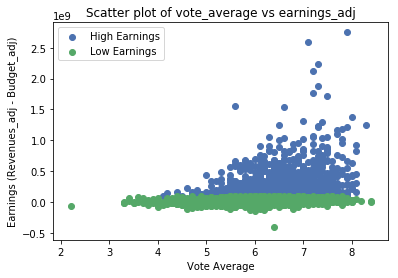

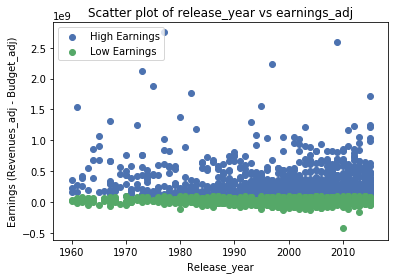

In [41]:
plt.figure()
plt.scatter(df_high.vote_average, df_high.earnings_adj,label='High Earnings')
plt.scatter(df_low.vote_average, df_low.earnings_adj,label='Low Earnings')
plt.legend(loc='upper left')
graph_labels('Scatter plot of vote_average vs earnings_adj','Vote Average','Earnings (Revenues_adj - Budget_adj)')
plt.show()

plt.scatter(df_high.release_year, df_high.earnings_adj,label='High Earnings')
plt.scatter(df_low.release_year, df_low.earnings_adj,label='Low Earnings')
plt.legend(loc='upper left')
graph_labels('Scatter plot of release_year vs earnings_adj','Release_year','Earnings (Revenues_adj - Budget_adj)')
plt.show()

In [226]:
# Pearson Low earnings (vote_average)
print(st.pearsonr(df_low.vote_average, df_low.earnings_adj)[0])
# Pearson High earnings (vote_average)
print(st.pearsonr(df_high.vote_average, df_high.earnings_adj)[0])
# Pearson Low earnings (release_year)
print(st.pearsonr(df_low.release_year, df_low.earnings_adj)[0])
# Pearson High earnings (release_year)
print(st.pearsonr(df_high.release_year, df_high.earnings_adj)[0])

0.199147946175279
0.29659918159092596
-0.05881498207217052
-0.12763937286040122


> Coefficients of Pearson are all < 0.5 => we can tell there are no 'linear' relation between those variables. Still there could be other type of relation.

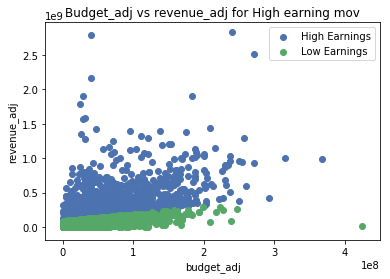

In [42]:
plt.figure()
plt.scatter(df_high.budget_adj, df_high.revenue_adj,label='High Earnings')
plt.scatter(df_low.budget_adj, df_low.revenue_adj,label='Low Earnings')
graph_labels('Budget_adj vs revenue_adj for High earning mov','budget_adj','revenue_adj')
plt.legend(loc='upper right')
plt.show()

> As high and low earning movies seems to have similar repartition qua budget, it's really on the value of the revenue
that high earning movies make the difference. And they aren't always having the biggest budget

### Research Question 2:  which genres are produced more from year to year?

> As we want to study the genres regarding the release year, we'll group by release_year

In [44]:
Q2_genre = df_Q2_dum.groupby('release_year').sum()

In [45]:
# we won't need for this analyse the columns 'id', 'popularity' and 'vote_average', so we decide to drop them
Q2_genre.drop(['id','popularity','vote_average'],axis=1,inplace=True)

> we would like to see amount of movies produced for each genres in function of the release year

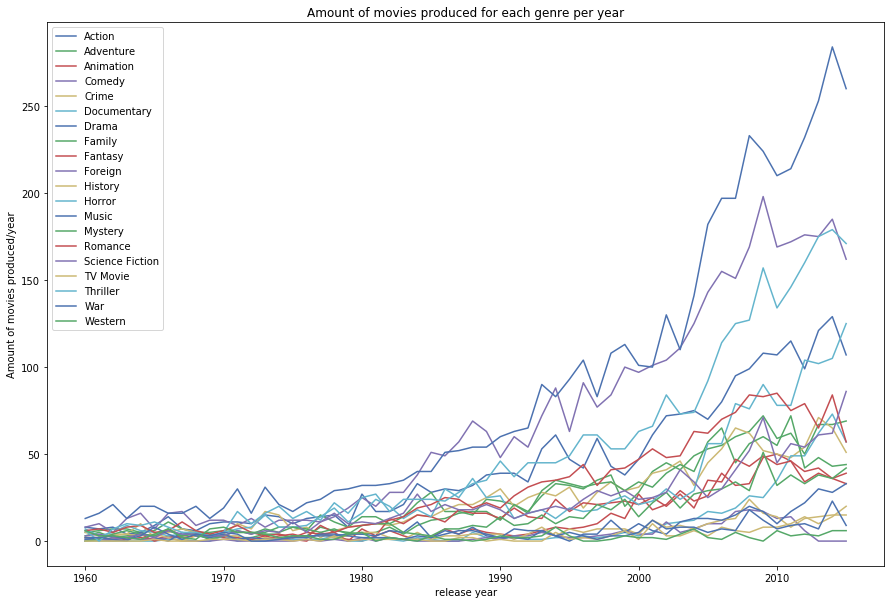

In [46]:
plt.figure(figsize=(15,10))
for col in Q2_genre.columns:
    Q2_genre[col].plot()

plt.legend(loc='upper left')
graph_labels('Amount of movies produced for each genre per year','release year','Amount of movies produced/year')
plt.show()
    

> As one could expect the amount of movies produced for most genres are increasing year over year. We can observe
that 4 genres are increasing more : Drama, Comdey, Thriller and Action.

> Let's have a look at the means and see of this is consistent

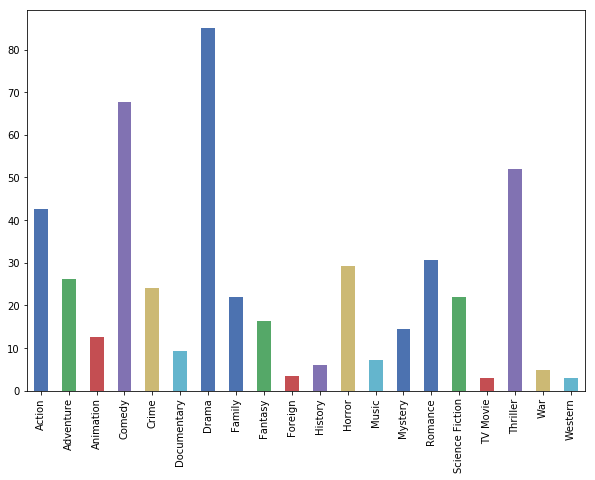

In [360]:
plt.figure(figsize=(10,7))
Q2_genre.mean().plot(kind='bar')

> Here a again looking at the means we see that 4 of the genres are above the rest:
Drama, Comedy, Thriller and Action

<a id='conclusions'></a>
## Conclusions


> ** First Comments** : To run this analysis, some limitations are important to be mentioned as for example no Machine
Learning, Inferential Statistics or Statistical Tests were used.

> ** Limitations** : Revenue_adj and budget_adj, have a lot of zeros, from the 10866 lines, 7012 lines had to be dropped (> 70% of the dataset). This have an impact on the representativeness of the the remaining dataset in regards to the population.

> After analysing the cleaned dataset TMDb, some observations could be made (taking into account the limitations exposed in 'First Comments').

> ** Q1 - Properties of High Earning Movies:**
Using scatterplots and verifying with Pearsons Coefficients no linear correlation could be found between:
vote_average vs earnings_adj nor for release_year vs earnings_adj.

> After having separated High Earning Movies of the Low Earning Movies (based on the mean earning_adj), we could notice that **on the average**:
> 1. High Earning movies get higher vote_averages
> 2. High Earning movies last longer
> 3. High Earning movies were released earlier



> ** Q2 - Which genres of movies are released more year after year:**
After separating the different genres in separated column and putting this in graph, we could notice that:
> 1. Most genres saw their amount of movies released increase year after year
> 2. Four genres get the most increases: Drama, Comedy, Thriller and Action